In [5]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
from tqdm import tqdm

In [3]:
dataset = load_dataset("imdb")
print(dataset)
imdb_test = dataset['test']
imdb_train = dataset['train']

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [10]:
# Bert-base-cased, tokenize
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

# Test on IMDB dataset
imdb_test_encodings = tokenizer(list(imdb_test['text']), truncation=True, padding=True)
imdb_test_labels = torch.tensor(list(imdb_test['label']))
imdb_test_dataset = TensorDataset(torch.tensor(imdb_test_encodings['input_ids']),
                                  torch.tensor(imdb_test_encodings['attention_mask']),
                                  imdb_test_labels)
imdb_test_loader = DataLoader(imdb_test_dataset, batch_size=16, shuffle=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
model.eval()
with torch.no_grad():
    imdb_correct = 0
    with tqdm(total=len(imdb_test_loader), desc='testing') as pbar:
        for batch in imdb_test_loader:
            input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            imdb_correct += (logits.argmax(dim=1) == labels).float().sum().item()
            pbar.update(1)
        imdb_accuracy = imdb_correct / len(imdb_test)

print('imdb bert vanilla accuracy:', imdb_accuracy)

testing: 100%|██████████| 1563/1563 [01:37<00:00, 15.98it/s]

imdb bert vanilla accuracy: 0.5


In [12]:
# Train on IMDB dataset
imdb_train_encodings = tokenizer(list(imdb_train['text']), truncation=True, padding=True)
imdb_train_labels = torch.tensor(list(imdb_train['label']))
imdb_train_dataset = TensorDataset(torch.tensor(imdb_train_encodings['input_ids']),
                                   torch.tensor(imdb_train_encodings['attention_mask']),
                                   imdb_train_labels)
imdb_train_loader = DataLoader(imdb_train_dataset, batch_size=16, shuffle=True)

optimizer = AdamW(model.parameters(), lr=1e-5)
for epoch in range(3):
    for batch in imdb_train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(3):
    model.train()
    train_loss = 0
    train_correct = 0
    for batch in imdb_train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        train_loss += loss.item()
        train_correct += (logits.argmax(dim=1) == labels).float().sum().item()
        loss.backward()
        optimizer.step()
    train_loss /= len(imdb_train_loader)
    train_accuracy = train_correct / len(imdb_train)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    with torch.no_grad():
        test_correct = 0
        for batch in imdb_test_loader:
            input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            test_correct += (logits.argmax(dim=1) == labels).float().sum().item()
        test_accuracy = test_correct / len(imdb_test)
        test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch + 1}: train_loss={train_loss:.4f}, train_accuracy={train_accuracy:.4f}, test_accuracy={test_accuracy:.4f}")

/home/zmengaf/miniconda3/envs/rcfda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: train_loss=0.0401, train_accuracy=0.9872, test_accuracy=0.9364
Epoch 2: train_loss=0.0250, train_accuracy=0.9921, test_accuracy=0.9379
Epoch 3: train_loss=0.0190, train_accuracy=0.9943, test_accuracy=0.9313


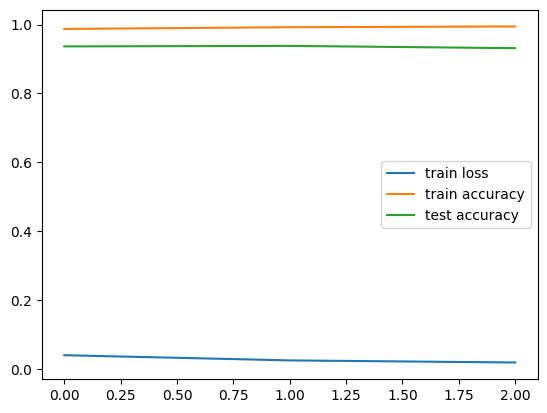

In [14]:

import matplotlib.pyplot as plt

plt.plot(train_losses, label='train loss')
plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracy')
plt.legend()
plt.show()